In [1]:
import time
inicio = time.time()

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.under_sampling import ClusterCentroids
# el muestreo aleatorio simple sin reemplazamiento no sirve porque no capta la variabilidad de la clase minoritaria.
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import LeaveOneOut

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

# Se importan los datos

In [3]:
df = pd.read_excel("..//Base_datos_Clasificacion binaria.xlsx", index_col = 0)

In [4]:
df

,Licitacion reparto,Importe presupuestado,Importe adjudicado,MP,Empresa sancionada,UTE
0,0,1738093.21,1484428.72,6,1,0
1,0,469670.24,272492.00,4,0,0
2,0,1025088.19,707310.85,1,0,0
3,0,999890.00,497621.36,6,0,0
4,0,72598.27,47508.92,1,1,0
...,...,...,...,...,...,...
2211,1,5542028.88,5514320.00,6,1,0
2212,1,6095782.00,5100555.00,6,1,0
2213,1,3752906.00,3744400.00,6,1,0
2214,1,23896564.00,19547338.00,6,0,1


# Se trata el desbalanceo de clases mediante una tecnica de Infra - Muestreo. Hay que instalar la libreria imbalanced - learn

In [5]:
y = df["Licitacion reparto"]
X = df[df.columns[1:]]

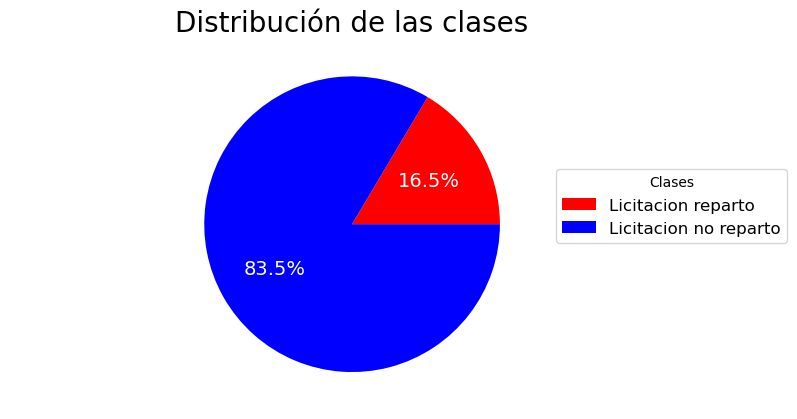

In [6]:
datos = [len(y[y == 1]), len(y[y == 0])]
etiquetas = ['Licitacion reparto', 'Licitacion no reparto']
colores = ['red', 'blue']

plt.pie(datos, labels = etiquetas, colors = colores, autopct = '%1.1f%%', textprops = {'fontsize': 14, 'color': 'white'})
plt.title('Distribución de las clases', fontsize = 20)
plt.legend(title = "Clases", bbox_to_anchor=(1.7, 0.55), loc='right', fontsize = 12)
plt.show()

# Codificacion OneHotEncoder

In [7]:
codificador = OneHotEncoder()

In [8]:
df[["MP", "Empresa sancionada", "UTE"]] = df[["MP", "Empresa sancionada", "UTE"]].astype("float")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2215
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Licitacion reparto     2216 non-null   int64  
 1   Importe presupuestado  2216 non-null   float64
 2   Importe adjudicado     2216 non-null   float64
 3   MP                     2216 non-null   float64
 4   Empresa sancionada     2216 non-null   float64
 5   UTE                    2216 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 121.2 KB


In [9]:
df

,Licitacion reparto,Importe presupuestado,Importe adjudicado,MP,Empresa sancionada,UTE
0,0,1738093.21,1484428.72,6.0,1.0,0.0
1,0,469670.24,272492.00,4.0,0.0,0.0
2,0,1025088.19,707310.85,1.0,0.0,0.0
3,0,999890.00,497621.36,6.0,0.0,0.0
4,0,72598.27,47508.92,1.0,1.0,0.0
...,...,...,...,...,...,...
2211,1,5542028.88,5514320.00,6.0,1.0,0.0
2212,1,6095782.00,5100555.00,6.0,1.0,0.0
2213,1,3752906.00,3744400.00,6.0,1.0,0.0
2214,1,23896564.00,19547338.00,6.0,0.0,1.0


In [10]:
codificacion = codificador.fit_transform(df[["MP"]])

mercados = pd.DataFrame(codificacion.toarray(),
                        columns = ["MP1", "MP4", "MP6"])
df.drop("MP", axis = 1, inplace = True)
df.reset_index(inplace = True, drop = True)
df = pd.concat([df, mercados], axis = 1)
df

,Licitacion reparto,Importe presupuestado,Importe adjudicado,Empresa sancionada,UTE,MP1,MP4,MP6
0,0,1738093.21,1484428.72,1.0,0.0,0.0,0.0,1.0
1,0,469670.24,272492.00,0.0,0.0,0.0,1.0,0.0
2,0,1025088.19,707310.85,0.0,0.0,1.0,0.0,0.0
3,0,999890.00,497621.36,0.0,0.0,0.0,0.0,1.0
4,0,72598.27,47508.92,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2211,1,5542028.88,5514320.00,1.0,0.0,0.0,0.0,1.0
2212,1,6095782.00,5100555.00,1.0,0.0,0.0,0.0,1.0
2213,1,3752906.00,3744400.00,1.0,0.0,0.0,0.0,1.0
2214,1,23896564.00,19547338.00,0.0,1.0,0.0,0.0,1.0


In [11]:
y = df["Licitacion reparto"]
X = df[df.columns[1:]]

In [12]:
nombre_clases = ["Licitacion no reparto", "Licitacion reparto"]
nombre_predicciones = list(map(lambda x : x + " predicho", nombre_clases))

### Se utiliza la técnica "ClusterCentroids" que reemplaza las observaciones por un centroide dado por los k vecinos más cercanos.

In [13]:
# conda install -c conda-forge imbalanced-learn
cc = ClusterCentroids(random_state=123)
X_res, y_res = cc.fit_resample(X, y)
df = pd.concat([y_res, X_res], axis = 1)
df

,Licitacion reparto,Importe presupuestado,Importe adjudicado,Empresa sancionada,UTE,MP1,MP4,MP6
0,0,6.776405e+04,6.312591e+04,0.287037,0.037037,0.083333,0.009259,0.907407
1,0,3.563140e+08,2.915613e+08,0.000000,1.000000,0.000000,0.000000,1.000000
2,0,6.513581e+07,6.513581e+07,0.000000,0.000000,1.000000,0.000000,0.000000
3,0,6.407947e+08,5.119260e+08,0.000000,1.000000,0.000000,0.000000,1.000000
4,0,2.458220e+07,2.428981e+07,1.000000,1.000000,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
725,1,5.542029e+06,5.514320e+06,1.000000,0.000000,0.000000,0.000000,1.000000
726,1,6.095782e+06,5.100555e+06,1.000000,0.000000,0.000000,0.000000,1.000000
727,1,3.752906e+06,3.744400e+06,1.000000,0.000000,0.000000,0.000000,1.000000
728,1,2.389656e+07,1.954734e+07,0.000000,1.000000,0.000000,0.000000,1.000000


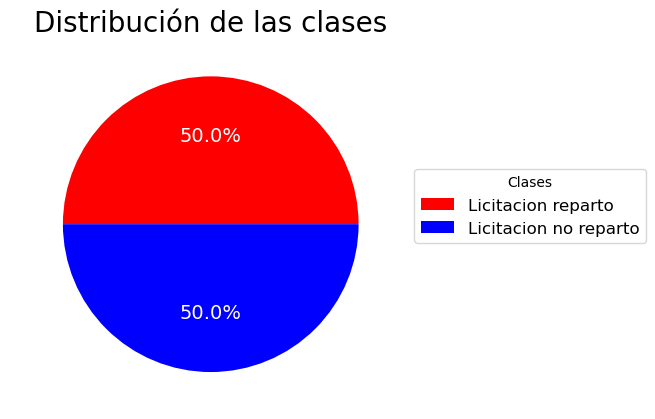

In [14]:
datos = [len(y_res[y_res == 1]), len(y_res[y_res == 0])]
etiquetas = ['Licitacion reparto', 'Licitacion no reparto']
colores = ['red', 'blue']

plt.pie(datos, labels = etiquetas, colors = colores, autopct = '%1.1f%%', textprops = {'fontsize': 14, 'color': 'white'})
plt.title('Distribución de las clases', fontsize = 20)
plt.legend(title = "Clases", bbox_to_anchor=(1.7, 0.55), loc='right', fontsize = 12)
plt.show()

In [15]:
df

,Licitacion reparto,Importe presupuestado,Importe adjudicado,Empresa sancionada,UTE,MP1,MP4,MP6
0,0,6.776405e+04,6.312591e+04,0.287037,0.037037,0.083333,0.009259,0.907407
1,0,3.563140e+08,2.915613e+08,0.000000,1.000000,0.000000,0.000000,1.000000
2,0,6.513581e+07,6.513581e+07,0.000000,0.000000,1.000000,0.000000,0.000000
3,0,6.407947e+08,5.119260e+08,0.000000,1.000000,0.000000,0.000000,1.000000
4,0,2.458220e+07,2.428981e+07,1.000000,1.000000,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
725,1,5.542029e+06,5.514320e+06,1.000000,0.000000,0.000000,0.000000,1.000000
726,1,6.095782e+06,5.100555e+06,1.000000,0.000000,0.000000,0.000000,1.000000
727,1,3.752906e+06,3.744400e+06,1.000000,0.000000,0.000000,0.000000,1.000000
728,1,2.389656e+07,1.954734e+07,0.000000,1.000000,0.000000,0.000000,1.000000


In [16]:
df[df.columns[4:]] = df[df.columns[4:]].applymap(lambda x : 1 if x >= 0.5 else 0)
df[df.columns[4:]]

,UTE,MP1,MP4,MP6
0,0,0,0,1
1,1,0,0,1
2,0,1,0,0
3,1,0,0,1
4,1,1,0,0
...,...,...,...,...
725,0,0,0,1
726,0,0,0,1
727,0,0,0,1
728,1,0,0,1


In [17]:
df

,Licitacion reparto,Importe presupuestado,Importe adjudicado,Empresa sancionada,UTE,MP1,MP4,MP6
0,0,6.776405e+04,6.312591e+04,0.287037,0,0,0,1
1,0,3.563140e+08,2.915613e+08,0.000000,1,0,0,1
2,0,6.513581e+07,6.513581e+07,0.000000,0,1,0,0
3,0,6.407947e+08,5.119260e+08,0.000000,1,0,0,1
4,0,2.458220e+07,2.428981e+07,1.000000,1,1,0,0
...,...,...,...,...,...,...,...,...
725,1,5.542029e+06,5.514320e+06,1.000000,0,0,0,1
726,1,6.095782e+06,5.100555e+06,1.000000,0,0,0,1
727,1,3.752906e+06,3.744400e+06,1.000000,0,0,0,1
728,1,2.389656e+07,1.954734e+07,0.000000,1,0,0,1


# Se estandarizan y normalizan los predictores numericos

In [18]:
predictores_numericos = df[["Importe presupuestado", "Importe adjudicado"]]

In [19]:
scaler = StandardScaler()
stand = scaler.fit_transform(predictores_numericos)

In [20]:
df[["Importe presupuestado", "Importe adjudicado"]] = stand
predictores_numericos = df[["Importe presupuestado", "Importe adjudicado"]]
predictores_numericos

,Importe presupuestado,Importe adjudicado
0,-0.404502,-0.411394
1,5.691897,5.257115
2,0.709000,0.854017
3,10.560180,9.542354
4,0.015011,0.059721
...,...,...
725,-0.310822,-0.305389
726,-0.301345,-0.313435
727,-0.341439,-0.339807
728,0.003277,-0.032502


In [21]:
norm = (predictores_numericos - predictores_numericos.min()) / (predictores_numericos.max() - predictores_numericos.min())

In [22]:
df[["Importe presupuestado", "Importe adjudicado"]] = norm
predictores_numericos = df[["Importe presupuestado", "Importe adjudicado"]]
predictores_numericos

,Importe presupuestado,Importe adjudicado
0,0.000069,0.000085
1,0.556034,0.569521
2,0.101616,0.127203
3,1.000000,1.000000
4,0.038327,0.047411
...,...,...
725,0.008613,0.010734
726,0.009477,0.009925
727,0.005821,0.007276
728,0.037257,0.038147


In [23]:
df

,Licitacion reparto,Importe presupuestado,Importe adjudicado,Empresa sancionada,UTE,MP1,MP4,MP6
0,0,0.000069,0.000085,0.287037,0,0,0,1
1,0,0.556034,0.569521,0.000000,1,0,0,1
2,0,0.101616,0.127203,0.000000,0,1,0,0
3,0,1.000000,1.000000,0.000000,1,0,0,1
4,0,0.038327,0.047411,1.000000,1,1,0,0
...,...,...,...,...,...,...,...,...
725,1,0.008613,0.010734,1.000000,0,0,0,1
726,1,0.009477,0.009925,1.000000,0,0,0,1
727,1,0.005821,0.007276,1.000000,0,0,0,1
728,1,0.037257,0.038147,0.000000,1,0,0,1


In [24]:
nombre_clases = ["Licitacion no reparto", "Licitacion reparto"]
nombre_predicciones = list(map(lambda x : x + " predicho", nombre_clases))

# Se hace la estimacion por Gradient Boosting Tree

In [25]:
X = df[df.columns[1:]]
y = df["Licitacion reparto"]

loo = LeaveOneOut()
gbt = GradientBoostingClassifier(random_state = 123) 
# random_state sirve para controlar la aleatoriedad del clasificador en los resultados
predicciones = []
prob_predicciones = []

n_observaciones = 0
for train_index, test_index in loo.split(X) :
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    gbt.fit(X_train, y_train)
    y_pred = gbt.predict(X_test)
    y_pred_prob = gbt.predict_proba(X_test)
    predicciones.append(int(y_pred))
    prob_predicciones.append(y_pred_prob[0][1])

In [26]:
gbt.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 123,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

# CURVA ROC. El punto optimo es = (fpr = 0, tpr = 1)

In [27]:
auc_score = roc_auc_score(y, prob_predicciones)
auc_score

0.9362732219928692

In [28]:
fpr, tpr, thresholds = roc_curve(y, prob_predicciones)
#fpr es 1 - especificidad = 1 - (TN / (FP + TN)) = FP / (FP + TN)
#tpr es la sensibilidad = TP / (TP + FN)

In [29]:
distances = np.linalg.norm(np.column_stack((fpr, tpr)) - np.array([0, 1]), axis=1)
optimal_threshold_index = np.argmin(distances)
optimal_threshold = thresholds[optimal_threshold_index]
optimal_threshold

0.5673595669046594

In [30]:
optimal_fpr = fpr[optimal_threshold_index]
optimal_fpr

0.0684931506849315

In [31]:
optimal_tpr = tpr[optimal_threshold_index]
optimal_tpr

0.810958904109589

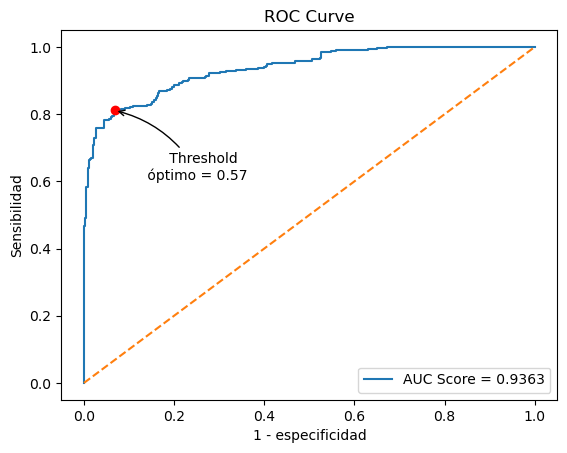

In [32]:
plt.plot(fpr, tpr, label = f'AUC Score = {auc_score:.4}')
plt.plot([0,1], linestyle="--")
plt.plot(optimal_fpr, optimal_tpr, 'ro')
plt.annotate(f'      Threshold\n óptimo = {optimal_threshold:.2}',
             xy=(optimal_fpr, optimal_tpr), xycoords='data',
             xytext=(+20, -50), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle="->", connectionstyle = "arc3, rad = .2"))
plt.ylabel('Sensibilidad')
plt.xlabel('1 - especificidad')
plt.title('ROC Curve')
plt.legend(loc = 'lower right')
plt.show()

# Metricas de la Matriz de Confusion

In [33]:
predicciones = pd.Series(predicciones, name = "Prediccion licitacion reparto")
prob_predicciones = pd.Series(prob_predicciones, name = "Prob prediccion")
cp = pd.concat([y, predicciones, prob_predicciones], axis = 1)
cp
# Este dataframe no contiene las predicciones calculadas en el punto optimo de la curva ROC.
# Contiene las predicciones calculadas segun el punto por defecto para determinar las predicciones del clasificador.

,Licitacion reparto,Prediccion licitacion reparto,Prob prediccion
0,0,0,0.011237
1,0,0,0.200476
2,0,0,0.059089
3,0,0,0.180004
4,0,0,0.399829
...,...,...,...
725,1,0,0.424413
726,1,0,0.304425
727,1,1,0.570736
728,1,0,0.104344


In [34]:
cp["Prediccion licitacion reparto en el punto optimo"] = 0
prediccion_final = cp["Prediccion licitacion reparto en el punto optimo"]
prediccion_final = cp.apply(lambda x: 1 if x["Prob prediccion"] >= optimal_threshold else 0, axis=1)
prediccion_final

0      0
1      0
2      0
3      0
4      0
      ..
725    0
726    0
727    1
728    0
729    0
Length: 730, dtype: int64

In [35]:
cp["Prediccion licitacion reparto en el punto optimo"] = prediccion_final
pd.concat([cp, prediccion_final], axis = 1)
cp.drop(columns = "Prediccion licitacion reparto", axis = 1, inplace = True)
cp

,Licitacion reparto,Prob prediccion,Prediccion licitacion reparto en el punto optimo
0,0,0.011237,0
1,0,0.200476,0
2,0,0.059089,0
3,0,0.180004,0
4,0,0.399829,0
...,...,...,...
725,1,0.424413,0
726,1,0.304425,0
727,1,0.570736,1
728,1,0.104344,0


In [36]:
cm = confusion_matrix(y, cp["Prediccion licitacion reparto en el punto optimo"]) # matriz de confusion
cm = pd.DataFrame(cm, columns = nombre_clases, index = nombre_predicciones)
cm # esta matriz de confusion esta calculada en el punto optimo de la curva

,Licitacion no reparto,Licitacion reparto
Licitacion no reparto predicho,340,25
Licitacion reparto predicho,69,296


In [37]:
TP = cm.iloc[1,1]
FN = cm.iloc[1,0]
FP = cm.iloc[0,1]
TN = cm.iloc[0,0]

In [38]:
Tasa_de_aciertos = (TP + TN) / len(df)
Tasa_de_aciertos

0.8712328767123287

In [39]:
Tasa_de_errores = 1 - Tasa_de_aciertos
Tasa_de_errores

0.12876712328767126

In [40]:
Sensibilidad = TP / (TP + FN)
Sensibilidad # se calculo antes. Es optimal_tpr

0.810958904109589

In [41]:
Tasa_de_falsos_negativos = 1 - Sensibilidad
Tasa_de_falsos_negativos

0.18904109589041096

In [42]:
Especificidad = TN / (FP + TN)
Especificidad # se calculo antes. Es optimal_fpr = 1 - Especificidad 

0.9315068493150684

In [43]:
Precision = TP / (TP + FP)
Precision

0.9221183800623053

In [44]:
FP / (FP + TP) # 1 - Precision

0.0778816199376947

In [45]:
F1 = (2 * Sensibilidad * Precision) / (Sensibilidad + Precision)
F1

0.8629737609329446

# Métricas de clasificación binaria en el punto óptimo

In [46]:
nombre_fichero = "Clasificacion binaria Infra_Muestreo gbt"

In [47]:
indice_resultados = ["Tasa de aciertos", "Sensibilidad", "Especificidad", "Precision", "F1"]
resultados_valores = [Tasa_de_aciertos, Sensibilidad, Especificidad, Precision, F1]

resultados = pd.DataFrame(data={f"{nombre_fichero}": resultados_valores},
                          index=indice_resultados)
resultados

,Clasificacion binaria Infra_Muestreo gbt
Tasa de aciertos,0.871233
Sensibilidad,0.810959
Especificidad,0.931507
Precision,0.922118
F1,0.862974


## Se exportan los datos

In [48]:
nombre_columna = list(resultados.columns)[0]
resultados.to_excel(f"Resultados de las métricas de {nombre_fichero}.xlsx")

# CURVA PR. El punto óptimo es = (precision = 1, recall = 1)

In [49]:
average_precision = average_precision_score(y, prob_predicciones)
average_precision

0.9469817849769606

In [50]:
precision, recall, thresholds = precision_recall_curve(y, prob_predicciones)
#precision = TP / (TP + FP)
#recall = sensibilidad = TP / (TP + FN)

In [51]:
distances = np.linalg.norm(np.column_stack((precision, recall)) - np.array([1, 1]), axis=1)
optimal_threshold_index = np.argmin(distances)
optimal_threshold = thresholds[optimal_threshold_index]
optimal_threshold

0.5673595669046594

In [52]:
optimal_precision = precision[optimal_threshold_index]
optimal_precision

0.9221183800623053

In [53]:
optimal_recall = recall[optimal_threshold_index]
optimal_recall

0.810958904109589

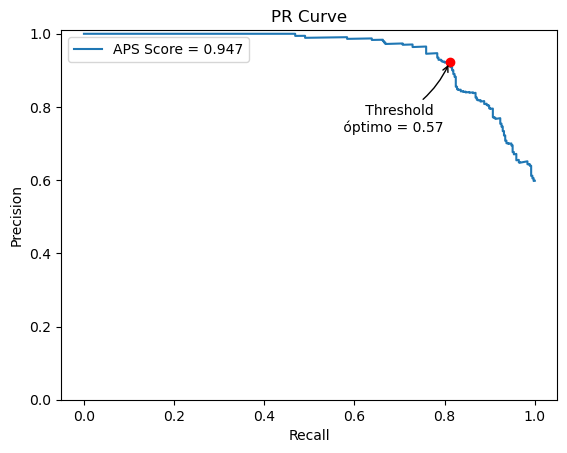

In [54]:
plt.plot(recall, precision, label = f'APS Score = {average_precision:.4}')
plt.plot(optimal_recall, optimal_precision, 'ro')
plt.annotate(f'      Threshold\n óptimo = {optimal_threshold:.2}',
             xy=(optimal_recall, optimal_precision), xycoords='data',
             xytext=(-80, -50) ,textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle="->", connectionstyle = "arc3, rad = .2"))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('PR Curve')
plt.legend(loc = 'upper left')
plt.ylim(0, 1.01)
plt.show()

# Se calcula cuanto tiempo ha transcurrido en la ejecucion de todo el notebook y se guarda el tiempo en un fichero de texto para almacenarlo.

In [55]:
fin = time.time()
tiempo_transcurrido = fin - inicio
minutos = int((tiempo_transcurrido % 3600) // 60)
segundos = int(tiempo_transcurrido % 60)
with open(f"Tiempo de ejecucion transcurrido en el notebook {nombre_fichero}.txt", "w") as f :
    f.write(f"Tiempo transcurrido: {minutos} minutos, {segundos} segundos")

In [56]:
print(f"Tiempo transcurrido: {minutos} minutos, {segundos} segundos")

Tiempo transcurrido: 1 minutos, 10 segundos
